# Classification of Driver Sex using LLM and GNN (v2 - Memory Optimized)

This notebook implements and compares a Large Language Model (BERT) and a Graph Neural Network (GNN) for classifying the sex of the driver using the road-safety.csv dataset. This version includes memory optimizations in the graph construction phase.

## 1. Setup and Library Imports

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc # Added for garbage collection

# Ensure GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories if they don't exist
os.makedirs("metrics", exist_ok=True)
os.makedirs("models", exist_ok=True)

Using device: cuda


## 2. Load and Inspect Dataset

In [6]:
# Load the dataset
data_path = "data/road-safety.csv"
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nDataset Description (all columns):")
print(df.describe(include='all'))

# Inspect the target variable 'SexofDriver'
target_col = 'SexofDriver'
print(f"\nUnique values in '{target_col}':")
print(df[target_col].value_counts(dropna=False))
print(f"\nMissing values in '{target_col}': {df[target_col].isnull().sum()}")

# It's common for -1 or other specific values to denote 'Unknown' or 'Not applicable'.
# We'll need to decide how to handle these (e.g., treat as a separate class, impute, or remove).
# For now, we'll proceed and LabelEncode them. If -1 is a significant category, it will become a class.

Dataset Head:
   Vehicle_Reference_df_res  Vehicle_Type  Vehicle_Manoeuvre  \
0                         1             9                 18   
1                         1             9                 18   
2                         2            20                 18   
3                         1             9                 18   
4                         1             9                 18   

   Vehicle_Location-Restricted_Lane  Hit_Object_in_Carriageway  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                                 0                          0   

   Hit_Object_off_Carriageway  Was_Vehicle_Left_Hand_Drive?  Age_of_Driver  \
0                           0                             0             33   
1                           0                   

## 3. Data Preprocessing
This section covers:
- Handling missing values (especially for the target `SexofDriver`).
- Encoding categorical features.
- Scaling numerical features.
- Preparing text data for BERT (if deemed useful for this task).
- Constructing a graph for GNN.
- Splitting data into training, validation, and test sets.

In [7]:
# --- Common Preprocessing ---

# Target variable: 'SexofDriver'
# Handle missing values in target: For classification, rows with missing target are often dropped.
# Let's check the proportion of missing values first.
if df[target_col].isnull().any():
    print(f"Warning: Target column '{target_col}' has {df[target_col].isnull().sum()} missing values. These rows will be dropped.")
    df.dropna(subset=[target_col], inplace=True)

# Convert target to integer if it's not, as LabelEncoder expects it.
# Values like -1 (often meaning 'unknown' or 'not recorded') will be treated as a distinct category.
df[target_col] = df[target_col].astype(int)


# Identify ID or high cardinality columns to exclude from features
id_cols = ['Vehicle_Reference_df_res', 'Casualty_Reference', 'accident_index', 'accident_reference']

# Identify feature types
all_cols = df.columns.tolist()

# Potential numerical features (excluding IDs and target)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_features if col not in id_cols + [target_col]]

# --- Text Data Preparation (for BERT) ---
# For predicting 'SexofDriver', text features might be less directly indicative than for 'accident_severity'.
# However, we can try combining features like 'Vehicle_Type', 'Age_of_Driver', 'Engine_Capacity_(CC)'.
# Note: 'Age_of_Driver' is numerical, so convert to string for concatenation.
text_cols_for_bert_candidates = ['Vehicle_Type', 'Age_of_Driver', 'Engine_Capacity_(CC)', 'Vehicle_Manoeuvre']
text_cols_for_bert = [col for col in text_cols_for_bert_candidates if col in df.columns]

# Convert all selected text columns to string to handle mixed types and NaNs before join
for col in text_cols_for_bert:
    df[col] = df[col].fillna('Unknown').astype(str) # Fill NaNs in text source columns

if not text_cols_for_bert:
    print("Warning: No suitable pre-defined text columns found for BERT. Using a placeholder text.")
    df['text_description'] = "driver and vehicle details"
else:
    df['text_description'] = df[text_cols_for_bert].apply(lambda x: ' '.join(x), axis=1)

print("\nSample text descriptions for BERT:")
print(df['text_description'].head())


# --- Feature Encoding and Scaling ---

# Label Encoding for the target variable 'SexofDriver'
label_encoder_target = LabelEncoder()
df['encoded_sex_of_driver'] = label_encoder_target.fit_transform(df[target_col])
labels = df['encoded_sex_of_driver'].values
num_classes = len(np.unique(labels))
print(f"\nNumber of classes for '{target_col}': {num_classes}")
print(f"Class distribution for '{target_col}': {np.bincount(labels)}")
print(f"Label mapping for '{target_col}': {dict(zip(label_encoder_target.classes_, label_encoder_target.transform(label_encoder_target.classes_)))}")


# One-Hot Encoding for categorical features
# Select categorical features (object type) that are not used in text_description and are not IDs
categorical_features_object = df.select_dtypes(include='object').columns.tolist()
categorical_features_for_ohe = [col for col in categorical_features_object if col not in text_cols_for_bert + id_cols + ['text_description']]

# Add other known categorical columns that might be numeric (e.g., Vehicle_Type if not used for text)
# For this task, let's be explicit. 'Vehicle_Type' was used for text.
# 'Propulsion_Code', 'Age_Band_of_Driver' might be categorical.
potential_numeric_categoricals = ['Vehicle_Location-Restricted_Lane', 'Was_Vehicle_Left_Hand_Drive?',
                                   'Propulsion_Code', 'Age_Band_of_Driver', 'Police_Force',
                                   'Local_Authority_(District)', 'Urban_or_Rural_Area']
for col in potential_numeric_categoricals:
    if col in df.columns and col not in text_cols_for_bert + id_cols + numerical_features: # ensure not already numerical or text
        if df[col].nunique() < 50: # Cardinality check
             categorical_features_for_ohe.append(col)
        else:
            print(f"Warning: Potential categorical feature '{col}' has high cardinality ({df[col].nunique()}) and will be excluded from OHE.")


categorical_features_for_ohe_final = []
for col in list(set(categorical_features_for_ohe)): # Use set to ensure unique columns
    # Fill NaNs in categorical features before OHE
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0]) # Fill with mode
    if df[col].nunique() < 50:
        categorical_features_for_ohe_final.append(col)
    else:
        print(f"Warning: Categorical feature '{col}' has high cardinality ({df[col].nunique()}) and will be excluded from OHE.")


if categorical_features_for_ohe_final:
    # Convert all OHE candidates to string to avoid issues with mixed types if some are numeric
    for col in categorical_features_for_ohe_final:
        df[col] = df[col].astype(str)
    encoder_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_categoricals = encoder_ohe.fit_transform(df[categorical_features_for_ohe_final])
    print(f"Shape of one-hot encoded categorical features: {encoded_categoricals.shape}")
else:
    encoded_categoricals = np.array([]).reshape(len(df), 0)
    print("No categorical features selected for OHE or none suitable after cardinality check.")

# Scaling numerical features
numerical_features_to_scale = [col for col in numerical_features if col not in [target_col, 'encoded_sex_of_driver'] + id_cols + text_cols_for_bert] # Avoid scaling features used for text if they were numeric

if numerical_features_to_scale:
    for col in numerical_features_to_scale: # Fill NaNs before scaling
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
    scaler = StandardScaler()
    scaled_numericals = scaler.fit_transform(df[numerical_features_to_scale])
    print(f"Shape of scaled numerical features: {scaled_numericals.shape}")
else:
    scaled_numericals = np.array([]).reshape(len(df), 0)
    print("No numerical features to scale.")

# Combine processed features for GNN
if scaled_numericals.size == 0 and encoded_categoricals.size == 0:
    combined_features_for_gnn = torch.empty((len(df), 0), dtype=torch.float)
elif scaled_numericals.size == 0:
    combined_features_for_gnn = torch.tensor(encoded_categoricals, dtype=torch.float)
elif encoded_categoricals.size == 0:
    combined_features_for_gnn = torch.tensor(scaled_numericals, dtype=torch.float)
else:
    combined_features_for_gnn = torch.tensor(np.concatenate((scaled_numericals, encoded_categoricals), axis=1), dtype=torch.float)

print(f"Shape of combined features for GNN: {combined_features_for_gnn.shape}")


# --- BERT Specific Preprocessing ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir="cache")
bert_encodings = tokenizer(df['text_description'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# --- Train, Validation, Test Split ---
indices = np.arange(len(labels))
train_indices, temp_indices, train_labels_split, temp_labels_split = train_test_split(
    indices, labels, test_size=0.3, random_state=42, stratify=labels
)
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_labels_split, test_size=0.5, random_state=42, stratify=temp_labels_split
)

print(f"\nTrain size: {len(train_indices)}, Validation size: {len(val_indices)}, Test size: {len(test_indices)}")

# Calculate class weights for handling imbalance
if len(train_indices) > 0:
    train_labels_for_weights = labels[train_indices]
    if len(np.unique(train_labels_for_weights)) > 1:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_for_weights), y=train_labels_for_weights)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        print(f"Class weights for '{target_col}': {class_weights_tensor}")
    else:
        print("Warning: Only one class present in training data for target. Using uniform weights.")
        class_weights_tensor = torch.ones(num_classes, dtype=torch.float).to(device)
else:
    print("Warning: Training set is empty. Using uniform weights.")
    class_weights_tensor = torch.ones(num_classes, dtype=torch.float).to(device)


Sample text descriptions for BERT:
0     9 33 1895.0 18
1     9 35 1560.0 18
2    20 50 5880.0 18
3     9 38 1896.0 18
4     9 22 1968.0 18
Name: text_description, dtype: object

Number of classes for 'SexofDriver': 2
Class distribution for 'SexofDriver': [55881 55881]
Label mapping for 'SexofDriver': {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
No categorical features selected for OHE or none suitable after cardinality check.
Shape of scaled numerical features: (111762, 26)
Shape of combined features for GNN: torch.Size([111762, 26])

Train size: 78233, Validation size: 16764, Test size: 16765
Class weights for 'SexofDriver': tensor([1.0000, 1.0000], device='cuda:0')


### 3.1. Graph Construction for GNN
Nodes are instances (e.g., vehicles/drivers). Edges can be based on similarity of features like `Age_of_Driver`, `Vehicle_Type`, or co-occurrence in the same accident (if data structure allows linking). We'll use cosine similarity of `combined_features_for_gnn`.

In [8]:
# Graph Construction
# import gc # Already imported in the first cell
from sklearn.neighbors import kneighbors_graph # New import for k-NN graph
import networkx as nx # Ensure networkx is available
from torch_geometric.data import Data # Ensure Data is available

# Initialize pyg_graph to ensure it's defined in all paths
pyg_graph = Data() 

if combined_features_for_gnn.shape[0] > 0 : # If there are samples
    if combined_features_for_gnn.shape[1] > 0: # If there are features for graph construction
        features_for_graph = combined_features_for_gnn.numpy()
        
        print(f"Constructing k-NN graph for {features_for_graph.shape[0]} samples...")
        n_neighbors_for_graph = 10  # Number of neighbors for k-NN
        
        # Using 'cosine' metric for kneighbors_graph.
        # mode='connectivity' gives binary matrix, edges indicate neighborhood.
        adjacency_matrix = kneighbors_graph(
            features_for_graph,
            n_neighbors=n_neighbors_for_graph,
            mode='connectivity', 
            metric='cosine',
            include_self=False, # Do not include self-loops by default for k-NN
            n_jobs=-1  # Use all available cores
        )
        print("k-NN adjacency matrix calculated.")

        # Convert the sparse adjacency matrix to a NetworkX graph
        G_knn = nx.from_scipy_sparse_array(adjacency_matrix) # Creates a DiGraph if not symmetric
        
        # To ensure an undirected graph, convert it.
        # This handles cases where A is a k-neighbor of B but B is not of A by taking the union of edges.
        G_undirected = G_knn.to_undirected()

        print(f"Graph: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges created using k-NN (k={n_neighbors_for_graph}).")
        
        del features_for_graph 
        del adjacency_matrix
        del G_knn # delete intermediate graph
        gc.collect() 

        pyg_graph = from_networkx(G_undirected)
        del G_undirected # delete networkx graph after conversion
        gc.collect()

    else: # Samples exist, but no features for graph construction (e.g. shape is (N,0))
        print("Samples exist but no features for graph construction. Creating a graph with no edges.")
        G_no_edges = nx.Graph()
        # Add nodes to the graph to match the number of samples
        for i in range(combined_features_for_gnn.shape[0]):
            G_no_edges.add_node(i)
        pyg_graph = from_networkx(G_no_edges)
        del G_no_edges
        gc.collect()

    # Assign features and labels to the pyg_graph object
    # combined_features_for_gnn and labels are from the preprocessing cell (ID: 364bc23f)
    pyg_graph.x = combined_features_for_gnn 
    pyg_graph.y = torch.tensor(labels, dtype=torch.long)

    # Assign masks
    # train_indices, val_indices, test_indices are from cell 364bc23f
    pyg_graph.train_mask = torch.zeros(pyg_graph.num_nodes, dtype=torch.bool)
    pyg_graph.val_mask = torch.zeros(pyg_graph.num_nodes, dtype=torch.bool)
    pyg_graph.test_mask = torch.zeros(pyg_graph.num_nodes, dtype=torch.bool)

    if len(train_indices) > 0: pyg_graph.train_mask[train_indices] = True
    if len(val_indices) > 0: pyg_graph.val_mask[val_indices] = True
    if len(test_indices) > 0: pyg_graph.test_mask[test_indices] = True
    
    pyg_graph = pyg_graph.to(device) # Move final graph to device

else: # No samples (e.g. df became empty after preprocessing)
    print("Skipping graph construction for GNN as there are no samples after preprocessing.")
    # Create a truly empty graph on the correct device
    pyg_graph.x = torch.empty((0, combined_features_for_gnn.shape[1] if combined_features_for_gnn.ndim == 2 and combined_features_for_gnn.shape[0] == 0 else 0), dtype=torch.float).to(device)
    pyg_graph.edge_index = torch.empty((2,0), dtype=torch.long).to(device)
    pyg_graph.y = torch.empty((0), dtype=torch.long).to(device)
    pyg_graph.train_mask = torch.empty((0), dtype=torch.bool).to(device)
    pyg_graph.val_mask = torch.empty((0), dtype=torch.bool).to(device)
    pyg_graph.test_mask = torch.empty((0), dtype=torch.bool).to(device)

# Print details of the final graph
print("\nFinal PyG Graph details:")
print(pyg_graph)
if pyg_graph.num_nodes > 0 : # Avoid issues if num_nodes is 0
    print(f"Number of training nodes for GNN: {pyg_graph.train_mask.sum().item()}")
else:
    print("Number of training nodes for GNN: 0")

# The GNN model cell (ID 3ba1f852) has checks for pyg_graph.x being None or featureless.
# It should handle an empty graph or graph with no features.

Constructing k-NN graph for 111762 samples...
k-NN adjacency matrix calculated.
Graph: 111762 nodes, 764849 edges created using k-NN (k=10).

Final PyG Graph details:
Data(edge_index=[2, 1529698], weight=[1529698], num_nodes=111762, x=[111762, 26], y=[111762], train_mask=[111762], val_mask=[111762], test_mask=[111762])
Number of training nodes for GNN: 78233


## 4. BERT Model Implementation

In [9]:
class CustomBERTDataset(Dataset):
    def __init__(self, encodings, labels, additional_features=None):
        self.encodings = encodings
        self.labels = labels
        self.additional_features = additional_features

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        if self.additional_features is not None and self.additional_features.shape[0] > 0: # Check if additional_features exist
            item['additional_features'] = self.additional_features[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

num_additional_bert_features = combined_features_for_gnn.shape[1] if combined_features_for_gnn is not None else 0

train_bert_dataset = CustomBERTDataset(
    encodings={key: val[train_indices] for key, val in bert_encodings.items()},
    labels=torch.tensor(labels[train_indices], dtype=torch.long),
    additional_features=combined_features_for_gnn[train_indices] if num_additional_bert_features > 0 else None
)
val_bert_dataset = CustomBERTDataset(
    encodings={key: val[val_indices] for key, val in bert_encodings.items()},
    labels=torch.tensor(labels[val_indices], dtype=torch.long),
    additional_features=combined_features_for_gnn[val_indices] if num_additional_bert_features > 0 else None
)
test_bert_dataset = CustomBERTDataset(
    encodings={key: val[test_indices] for key, val in bert_encodings.items()},
    labels=torch.tensor(labels[test_indices], dtype=torch.long),
    additional_features=combined_features_for_gnn[test_indices] if num_additional_bert_features > 0 else None
)

batch_size_bert = 16
train_bert_loader = DataLoader(train_bert_dataset, sampler=RandomSampler(train_bert_dataset), batch_size=batch_size_bert)
val_bert_loader = DataLoader(val_bert_dataset, sampler=SequentialSampler(val_bert_dataset), batch_size=batch_size_bert)
test_bert_loader = DataLoader(test_bert_dataset, sampler=SequentialSampler(test_bert_dataset), batch_size=batch_size_bert)


class BertClassifierWithAdditionalFeatures(nn.Module):
    def __init__(self, num_labels, num_additional_features=0):
        super(BertClassifierWithAdditionalFeatures, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', cache_dir="cache")
        self.dropout = nn.Dropout(0.1)
        classifier_input_size = self.bert.config.hidden_size
        if num_additional_features > 0:
            classifier_input_size += num_additional_features
        self.classifier = nn.Linear(classifier_input_size, num_labels)
        self.num_additional_features = num_additional_features

    def forward(self, input_ids, attention_mask, additional_features=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        if self.num_additional_features > 0 and additional_features is not None:
            additional_features = additional_features.to(pooled_output.device)
            if additional_features.ndim == 1 and self.num_additional_features > 0 : additional_features = additional_features.unsqueeze(-1)
            combined_features = torch.cat((pooled_output, additional_features), dim=1)
        else:
            combined_features = pooled_output
            
        combined_features = self.dropout(combined_features)
        logits = self.classifier(combined_features)
        return logits

bert_model_sex = BertClassifierWithAdditionalFeatures(
    num_labels=num_classes,
    num_additional_features=num_additional_bert_features
).to(device)

optimizer_bert_sex = Adam(bert_model_sex.parameters(), lr=2e-5)
loss_fn_bert_sex = CrossEntropyLoss(weight=class_weights_tensor)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### 4.1. BERT Model Training and Evaluation


Starting BERT training for SexofDriver...
Epoch 1/3
  BERT Batch 0/4890, Loss: 0.7005
  BERT Batch 100/4890, Loss: 0.6535
  BERT Batch 200/4890, Loss: 0.7241
  BERT Batch 300/4890, Loss: 0.6792
  BERT Batch 400/4890, Loss: 0.5012
  BERT Batch 500/4890, Loss: 0.5580
  BERT Batch 600/4890, Loss: 0.5443
  BERT Batch 700/4890, Loss: 0.5597
  BERT Batch 800/4890, Loss: 0.5746
  BERT Batch 900/4890, Loss: 0.5014
  BERT Batch 1000/4890, Loss: 0.5496
  BERT Batch 1100/4890, Loss: 0.5361
  BERT Batch 1200/4890, Loss: 0.4849
  BERT Batch 1300/4890, Loss: 0.5841
  BERT Batch 1400/4890, Loss: 0.5286
  BERT Batch 1500/4890, Loss: 0.5451
  BERT Batch 1600/4890, Loss: 0.6702
  BERT Batch 1700/4890, Loss: 0.6459
  BERT Batch 1800/4890, Loss: 0.5821
  BERT Batch 1900/4890, Loss: 0.4987
  BERT Batch 2000/4890, Loss: 0.5418
  BERT Batch 2100/4890, Loss: 0.5360
  BERT Batch 2200/4890, Loss: 0.5811
  BERT Batch 2300/4890, Loss: 0.6173
  BERT Batch 2400/4890, Loss: 0.5329
  BERT Batch 2500/4890, Loss: 0.57

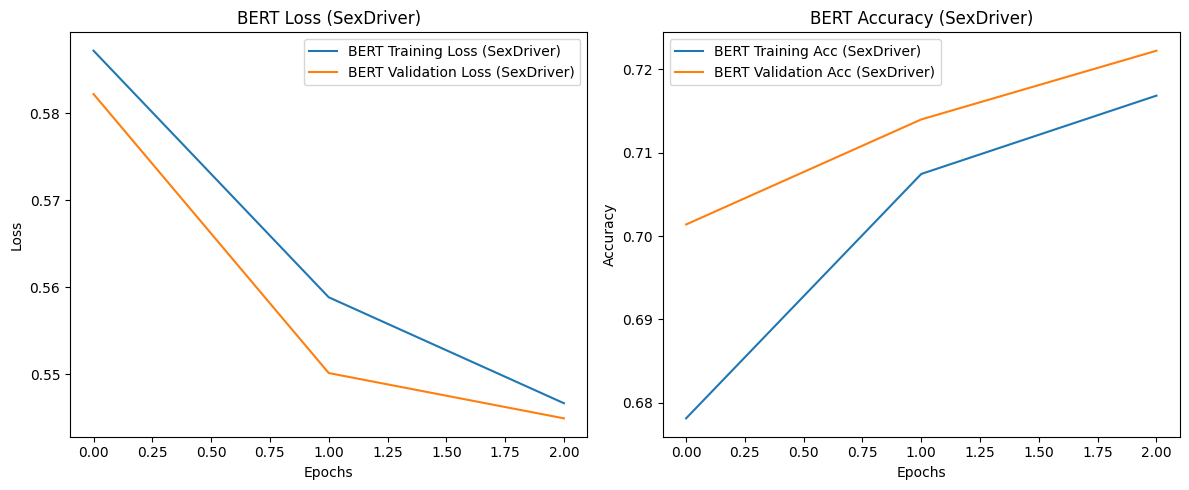


BERT Test (SexDriver): Acc: 0.7216, P: 0.7237, R: 0.7216, F1: 0.7209


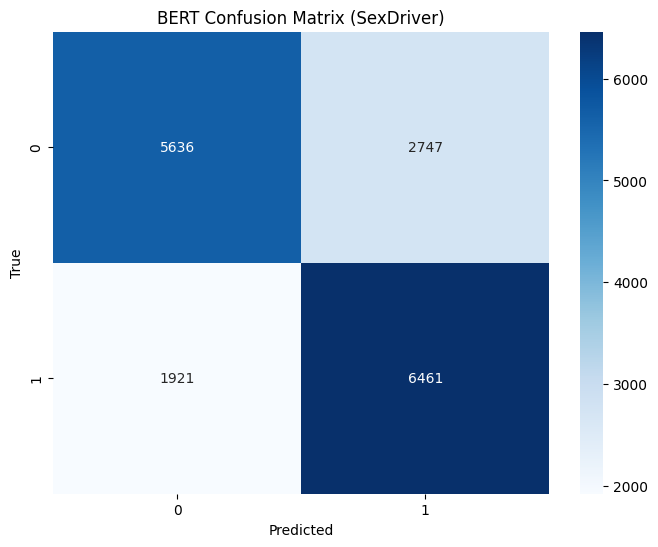

In [10]:
def train_bert_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)
        additional_features = batch.get('additional_features')
        if additional_features is not None and model.num_additional_features > 0:
             additional_features = additional_features.to(device)
        else:
            additional_features = None # Ensure it's None if not used by model

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, additional_features=additional_features)
        loss = loss_fn(outputs, labels_batch)
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels_batch)
        total_samples += labels_batch.size(0)
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()
        total_loss += loss.item()
        if batch_idx % 100 == 0: print(f"  BERT Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item():.4f}")
    return correct_predictions.double() / total_samples, total_loss / len(data_loader)

def eval_bert_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0; correct_predictions = 0; total_samples = 0
    all_preds = []; all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)
            additional_features = batch.get('additional_features')
            if additional_features is not None and model.num_additional_features > 0:
                 additional_features = additional_features.to(device)
            else:
                additional_features = None

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, additional_features=additional_features)
            loss = loss_fn(outputs, labels_batch)
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels_batch)
            total_samples += labels_batch.size(0)
            total_loss += loss.item()
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels_batch.cpu().numpy())
    accuracy = correct_predictions.double() / total_samples
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    return accuracy, avg_loss, precision, recall, f1, all_labels, all_preds

bert_epochs_sex = 3
bert_train_losses_sex, bert_val_losses_sex = [], []
bert_train_accuracies_sex, bert_val_accuracies_sex = [], []

print("\nStarting BERT training for SexofDriver...")
for epoch in range(bert_epochs_sex):
    print(f"Epoch {epoch + 1}/{bert_epochs_sex}")
    train_acc, train_loss = train_bert_epoch(bert_model_sex, train_bert_loader, loss_fn_bert_sex, optimizer_bert_sex, device)
    print(f"  BERT Training: Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
    bert_train_losses_sex.append(train_loss)
    bert_train_accuracies_sex.append(train_acc.cpu().item() if torch.is_tensor(train_acc) else train_acc)

    val_acc, val_loss, val_prec, val_rec, val_f1, _, _ = eval_bert_model(bert_model_sex, val_bert_loader, loss_fn_bert_sex, device)
    print(f"  BERT Validation: Acc: {val_acc:.4f}, Loss: {val_loss:.4f}, P: {val_prec:.4f}, R: {val_rec:.4f}, F1: {val_f1:.4f}")
    bert_val_losses_sex.append(val_loss)
    bert_val_accuracies_sex.append(val_acc.cpu().item() if torch.is_tensor(val_acc) else val_acc)

torch.save(bert_model_sex.state_dict(), "models/bert_classifier_sexofdriver.pth")
print("BERT (SexofDriver) model saved.")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(bert_train_losses_sex, label='BERT Training Loss (SexDriver)'); plt.plot(bert_val_losses_sex, label='BERT Validation Loss (SexDriver)'); plt.title('BERT Loss (SexDriver)'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.savefig("metrics/bert_sexofdriver_loss.png")
plt.subplot(1, 2, 2); plt.plot(bert_train_accuracies_sex, label='BERT Training Acc (SexDriver)'); plt.plot(bert_val_accuracies_sex, label='BERT Validation Acc (SexDriver)'); plt.title('BERT Accuracy (SexDriver)'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.savefig("metrics/bert_sexofdriver_accuracy.png"); plt.show()

test_acc_bert_sex, _, test_prec_bert_sex, test_rec_bert_sex, test_f1_bert_sex, lbls_bert_sex, preds_bert_sex = eval_bert_model(bert_model_sex, test_bert_loader, loss_fn_bert_sex, device)
print(f"\nBERT Test (SexDriver): Acc: {test_acc_bert_sex:.4f}, P: {test_prec_bert_sex:.4f}, R: {test_rec_bert_sex:.4f}, F1: {test_f1_bert_sex:.4f}")
cm_bert_sex = confusion_matrix(lbls_bert_sex, preds_bert_sex); plt.figure(figsize=(8,6)); sns.heatmap(cm_bert_sex, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_target.classes_, yticklabels=label_encoder_target.classes_); plt.title('BERT Confusion Matrix (SexDriver)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.savefig("metrics/bert_sexofdriver_cm.png"); plt.show()

## 5. GNN Model Implementation

In [11]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=64):
        super(GNNModel, self).__init__()
        self.conv1 = SAGEConv(num_node_features, hidden_channels) # or GATConv
        self.conv2 = SAGEConv(hidden_channels, num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        if x is None or x.shape[1] == 0: # Handle case with no node features
             # If no features, GNN might not learn much. Could use a constant feature vector or one-hot encode nodes.
             # For now, this will likely lead to poor performance if x is empty.
             # A better approach would be to ensure x always has some features, even if just node IDs OHE.
             # Or, use a GNN layer that doesn't strictly require features if graph structure is rich.
             # This example assumes x will have features from preprocessing.
             # If x is truly empty, we might pass a tensor of ones or zeros of appropriate shape for the first layer.
             # However, SAGEConv expects features.
             # A simple fallback if x is None or featureless:
             # x = torch.ones((data.num_nodes, 1), device=edge_index.device) # Minimal feature
             # This requires adjusting num_node_features in constructor or handling it dynamically.
             # For this code, we assume preprocessing provides valid x.
             pass


        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

if pyg_graph.x is None or pyg_graph.x.shape[1] == 0:
    print("Error: GNN node features (pyg_graph.x) are missing or empty. Cannot initialize GNN model robustly. Using a placeholder for num_node_features=1.")
    # This is a fallback. Ideally, ensure combined_features_for_gnn always has content or handle featureless graphs appropriately.
    num_gnn_node_features = 1 # Placeholder
    # Create dummy features if none exist to prevent crash, though model won't learn meaningfully from them.
    if pyg_graph.x is None or pyg_graph.x.shape[0] != pyg_graph.num_nodes: # If x is None or wrong shape
        pyg_graph.x = torch.ones((pyg_graph.num_nodes, num_gnn_node_features), device=device)
    elif pyg_graph.x.shape[1] == 0: # If x exists but has no features
        pyg_graph.x = torch.ones((pyg_graph.num_nodes, num_gnn_node_features), device=device)

    gnn_model_sex = GNNModel(
        num_node_features=num_gnn_node_features, # Use placeholder
        num_classes=num_classes
    ).to(device)
else:
    gnn_model_sex = GNNModel(
        num_node_features=pyg_graph.num_node_features,
        num_classes=num_classes
    ).to(device)

optimizer_gnn_sex = torch.optim.Adam(gnn_model_sex.parameters(), lr=0.01, weight_decay=5e-4)
# Using lambda for loss_fn_gnn to correctly pass class_weights_tensor which is on device
loss_fn_gnn_sex = lambda out, target_labels: F.nll_loss(out, target_labels, weight=class_weights_tensor.to(out.device))


### 5.1. GNN Model Training and Evaluation


Starting GNN training for SexofDriver...
Epoch 1/50 | GNN Train Acc: 0.5379, Loss: 0.7541 | Val Acc: 0.6000, Loss: 0.6727, F1: 0.5706
Epoch 11/50 | GNN Train Acc: 0.6858, Loss: 0.6080 | Val Acc: 0.6917, Loss: 0.5960, F1: 0.6916
Epoch 11/50 | GNN Train Acc: 0.6858, Loss: 0.6080 | Val Acc: 0.6917, Loss: 0.5960, F1: 0.6916
Epoch 21/50 | GNN Train Acc: 0.6930, Loss: 0.5882 | Val Acc: 0.6980, Loss: 0.5815, F1: 0.6979
Epoch 21/50 | GNN Train Acc: 0.6930, Loss: 0.5882 | Val Acc: 0.6980, Loss: 0.5815, F1: 0.6979
Epoch 31/50 | GNN Train Acc: 0.6995, Loss: 0.5805 | Val Acc: 0.7031, Loss: 0.5756, F1: 0.7026
Epoch 31/50 | GNN Train Acc: 0.6995, Loss: 0.5805 | Val Acc: 0.7031, Loss: 0.5756, F1: 0.7026
Epoch 41/50 | GNN Train Acc: 0.7051, Loss: 0.5750 | Val Acc: 0.7075, Loss: 0.5712, F1: 0.7074
Epoch 41/50 | GNN Train Acc: 0.7051, Loss: 0.5750 | Val Acc: 0.7075, Loss: 0.5712, F1: 0.7074
Epoch 50/50 | GNN Train Acc: 0.7088, Loss: 0.5705 | Val Acc: 0.7105, Loss: 0.5669, F1: 0.7104
GNN (SexofDriver) m

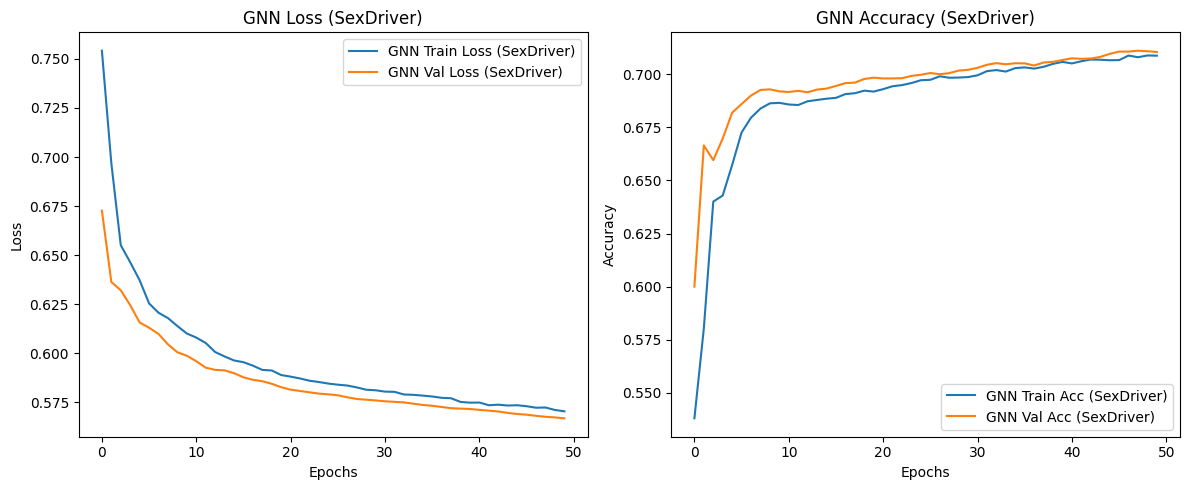


GNN Test (SexDriver): Acc: 0.7071, P: 0.7075, R: 0.7071, F1: 0.7070


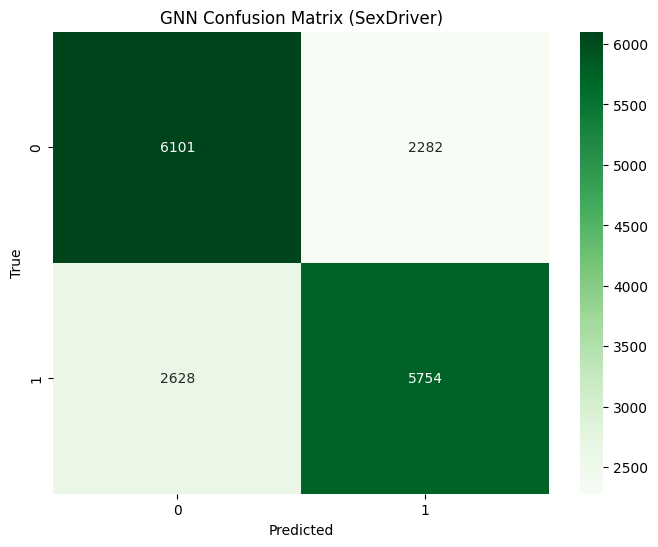

In [12]:
def train_gnn_epoch(model, data, optimizer, loss_fn_calculator):
    model.train()
    optimizer.zero_grad()
    # Ensure data.x is on the same device as the model
    data.x = data.x.to(next(model.parameters()).device) # Ensure features are on correct device
    out = model(data)
    loss = loss_fn_calculator(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pred = out[data.train_mask].max(1)[1]
    acc = pred.eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    return acc, loss.item()

def eval_gnn_model(model, data, loss_fn_calculator, mask):
    model.eval()
    with torch.no_grad():
        data.x = data.x.to(next(model.parameters()).device) # Ensure features are on correct device
        out = model(data)
        loss = loss_fn_calculator(out[mask], data.y[mask])
        pred = out[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        labels_np = data.y[mask].cpu().numpy(); preds_np = pred.cpu().numpy()
        precision, recall, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='weighted', zero_division=0)
    return acc, loss.item(), precision, recall, f1, labels_np, preds_np

gnn_epochs_sex = 50 # GNNs might need more epochs
gnn_train_losses_sex, gnn_val_losses_sex = [], []
gnn_train_accuracies_sex, gnn_val_accuracies_sex = [], []

if pyg_graph.num_edges == 0:
    print("Warning: GNN graph has no edges. GNN might not learn effectively.")
if pyg_graph.x is None or pyg_graph.x.shape[1] == 0 :
     print("Warning: GNN graph has no node features or 0-dim features. GNN might not learn effectively.")


print("\nStarting GNN training for SexofDriver...")
# Ensure pyg_graph is on the correct device before starting training loop
pyg_graph = pyg_graph.to(device)

for epoch in range(gnn_epochs_sex):
    # pyg_graph might have been moved to CPU by NetworkX conversion or other ops, ensure it's on device
    pyg_graph.x = pyg_graph.x.to(device)
    pyg_graph.edge_index = pyg_graph.edge_index.to(device)
    pyg_graph.y = pyg_graph.y.to(device)
    pyg_graph.train_mask = pyg_graph.train_mask.to(device)
    pyg_graph.val_mask = pyg_graph.val_mask.to(device)
    pyg_graph.test_mask = pyg_graph.test_mask.to(device)

    train_acc, train_loss = train_gnn_epoch(gnn_model_sex, pyg_graph, optimizer_gnn_sex, loss_fn_gnn_sex)
    gnn_train_losses_sex.append(train_loss); gnn_train_accuracies_sex.append(train_acc)
    val_acc, val_loss, val_prec, val_rec, val_f1, _, _ = eval_gnn_model(gnn_model_sex, pyg_graph, loss_fn_gnn_sex, pyg_graph.val_mask)
    gnn_val_losses_sex.append(val_loss); gnn_val_accuracies_sex.append(val_acc)
    if epoch % 10 == 0 or epoch == gnn_epochs_sex -1:
         print(f"Epoch {epoch+1}/{gnn_epochs_sex} | GNN Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}, Loss: {val_loss:.4f}, F1: {val_f1:.4f}")

torch.save(gnn_model_sex.state_dict(), "models/gnn_model_sexofdriver.pth")
print("GNN (SexofDriver) model saved.")

plt.figure(figsize=(12,5)); plt.subplot(1,2,1); plt.plot(gnn_train_losses_sex, label='GNN Train Loss (SexDriver)'); plt.plot(gnn_val_losses_sex, label='GNN Val Loss (SexDriver)'); plt.title('GNN Loss (SexDriver)'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.savefig("metrics/gnn_sexofdriver_loss.png")
plt.subplot(1,2,2); plt.plot(gnn_train_accuracies_sex, label='GNN Train Acc (SexDriver)'); plt.plot(gnn_val_accuracies_sex, label='GNN Val Acc (SexDriver)'); plt.title('GNN Accuracy (SexDriver)'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.savefig("metrics/gnn_sexofdriver_accuracy.png"); plt.show()

test_acc_gnn_sex, _, test_prec_gnn_sex, test_rec_gnn_sex, test_f1_gnn_sex, lbls_gnn_sex, preds_gnn_sex = eval_gnn_model(gnn_model_sex, pyg_graph, loss_fn_gnn_sex, pyg_graph.test_mask)
print(f"\nGNN Test (SexDriver): Acc: {test_acc_gnn_sex:.4f}, P: {test_prec_gnn_sex:.4f}, R: {test_rec_gnn_sex:.4f}, F1: {test_f1_gnn_sex:.4f}")
cm_gnn_sex = confusion_matrix(lbls_gnn_sex, preds_gnn_sex); plt.figure(figsize=(8,6)); sns.heatmap(cm_gnn_sex, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder_target.classes_, yticklabels=label_encoder_target.classes_); plt.title('GNN Confusion Matrix (SexDriver)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.savefig("metrics/gnn_sexofdriver_cm.png"); plt.show()

## 6. Comparative Analysis of Metrics


--- Comparative Metrics for SexofDriver Classification ---
BERT Test Metrics: Accuracy: 0.7216, Precision: 0.7237, Recall: 0.7216, F1: 0.7209
GNN Test Metrics:  Accuracy: 0.7071, Precision: 0.7075, Recall: 0.7071, F1: 0.7070


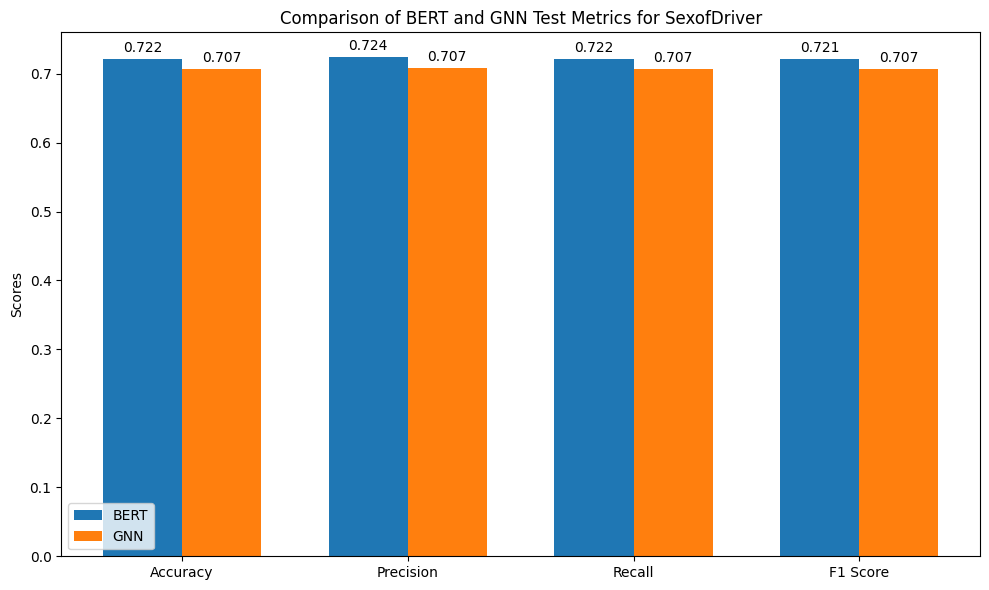

In [13]:
print("\n--- Comparative Metrics for SexofDriver Classification ---")
bert_metrics_sex = [test_acc_bert_sex, test_prec_bert_sex, test_rec_bert_sex, test_f1_bert_sex]
gnn_metrics_sex = [test_acc_gnn_sex, test_prec_gnn_sex, test_rec_gnn_sex, test_f1_gnn_sex]

# Convert tensor scores to float
bert_metrics_sex = [s.cpu().item() if torch.is_tensor(s) else s for s in bert_metrics_sex]
# gnn_metrics_sex are already floats from eval_gnn_model

print(f"BERT Test Metrics: Accuracy: {bert_metrics_sex[0]:.4f}, Precision: {bert_metrics_sex[1]:.4f}, Recall: {bert_metrics_sex[2]:.4f}, F1: {bert_metrics_sex[3]:.4f}")
print(f"GNN Test Metrics:  Accuracy: {gnn_metrics_sex[0]:.4f}, Precision: {gnn_metrics_sex[1]:.4f}, Recall: {gnn_metrics_sex[2]:.4f}, F1: {gnn_metrics_sex[3]:.4f}")

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x_axis = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x_axis - width/2, bert_metrics_sex, width, label='BERT')
rects2 = ax.bar(x_axis + width/2, gnn_metrics_sex, width, label='GNN')

ax.set_ylabel('Scores')
ax.set_title('Comparison of BERT and GNN Test Metrics for SexofDriver')
ax.set_xticks(x_axis)
ax.set_xticklabels(metrics_names)
ax.legend()

def autolabel(rects_ax):
    for rect in rects_ax:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
autolabel(rects1); autolabel(rects2)
fig.tight_layout(); plt.savefig("metrics/comparison_sexofdriver_summary.png"); plt.show()

## 7. Conclusion

Summarize the findings from this `SexofDriver` classification task.
- Which model performed better?
- Potential reasons for performance differences (e.g., nature of features, graph structure utility for this task).
- Limitations and potential future work.

## 7. Detailed Analysis and Sample Inference

--- Analyzing Sample (Original DataFrame Index: 26049) ---

Original Data for the Sample:
      Vehicle_Type Age_of_Driver Engine_Capacity_(CC) Vehicle_Manoeuvre  \
26049            9            49               1461.0                18   

       SexofDriver  Vehicle_Location-Restricted_Lane  \
26049            0                                 0   

       Hit_Object_in_Carriageway  Hit_Object_off_Carriageway  
26049                          0                           0  

Text Description (Input to BERT) for the Sample:
9 49 1461.0 18

True Label (SexofDriver): 0 (Encoded: 0)


--- Recap of Model Test Metrics ---
BERT Test Metrics: Accuracy: 0.7216, Precision: 0.7237, Recall: 0.7216, F1: 0.7209
GNN Test Metrics:  Accuracy: 0.7071, Precision: 0.7075, Recall: 0.7071, F1: 0.7070
(Note: Training/validation curves and overall comparison bar chart are in previous cells)

Confusion Matrix for BERT (SexDriver) - Test Set:


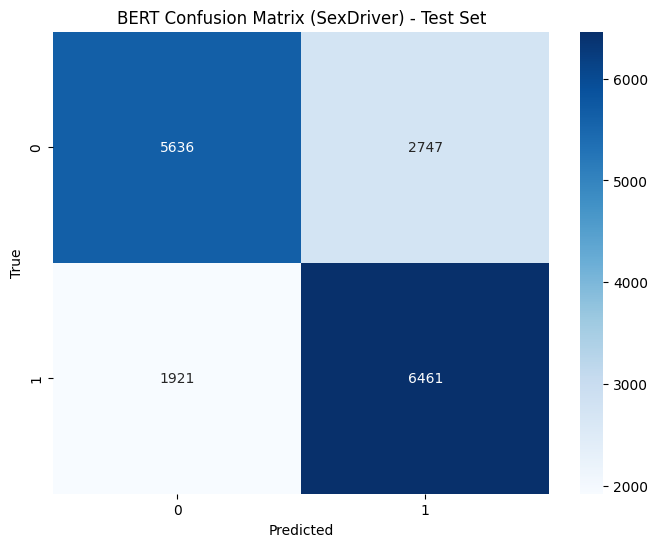


Confusion Matrix for GNN (SexDriver) - Test Set:


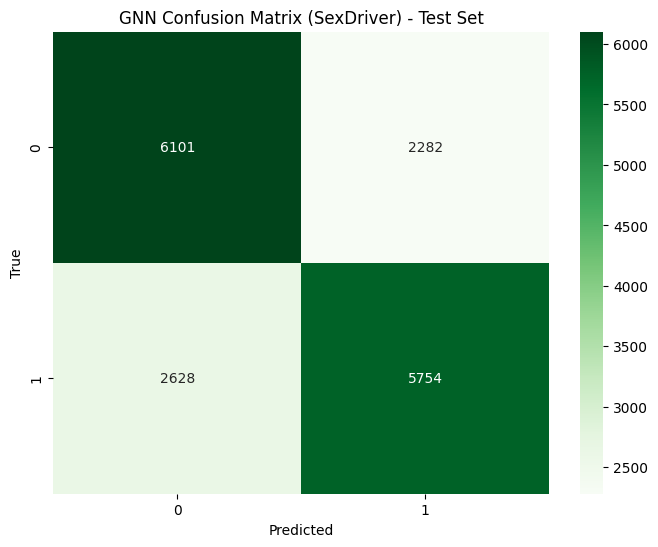



--- Inference for Sample (Original DataFrame Index: 26049) ---

--- Inputs to BERT Model for the Sample ---
Sample Additional Features for BERT (first 5): tensor([[-0.0938, -0.1948, -0.2731, -0.0438,  0.6342]], device='cuda:0')

BERT Model Prediction: 1 (Encoded: 1)
BERT Prediction Probabilities: 0: 0.4764, 1: 0.5236

--- Inputs to GNN Model for the Sample ---
GNN Node Features for sample 26049 (first 5): tensor([-0.0938, -0.1948, -0.2731, -0.0438,  0.6342], device='cuda:0')

GNN Model Prediction:  0 (Encoded: 0)
GNN Prediction Probabilities:  0: 0.5118, 1: 0.4882


--- Summary for Sample (Original DataFrame Index: 26049) ---
  True Label:          0 (Encoded: 0)
  BERT Prediction:     1 (Encoded: 1) - Correct: False
    BERT Probabilities: 0: 0.4764, 1: 0.5236 (Confidence in prediction: 0.5236)
  GNN Prediction:      0 (Encoded: 0) - Correct: True
    GNN Probabilities:  0: 0.5118, 1: 0.4882 (Confidence in prediction: 0.5118)


In [16]:
import torch
import seaborn as sns

import torch.nn.functional as F # Added for softmax, though torch.softmax can also be used
import matplotlib.pyplot as plt
# Assuming df, test_indices, text_cols_for_bert, target_col, numerical_features_to_scale,
# label_encoder_target, labels, bert_metrics_sex, gnn_metrics_sex, cm_bert_sex, cm_gnn_sex,
# bert_model_sex, bert_encodings, device, combined_features_for_gnn,
# pyg_graph, gnn_model_sex are defined and populated from previous cells.

print("## 7. Detailed Analysis and Sample Inference")

# --- 1. Select a Sample from the Test Set ---
if len(test_indices) > 0:
    sample_idx_in_test_set = 0 # Take the first sample from the test set
    sample_original_idx = test_indices[sample_idx_in_test_set]

    print(f"\n--- Analyzing Sample (Original DataFrame Index: {sample_original_idx}) ---")

    # --- 2. Show Sample Data from DataFrame ---
    print("\nOriginal Data for the Sample:")
    sample_data_display_cols = text_cols_for_bert + [target_col]
    if len(numerical_features_to_scale) > 0:
        sample_data_display_cols += numerical_features_to_scale[:min(3, len(numerical_features_to_scale))]
    sample_data_display = df.iloc[[sample_original_idx]][sample_data_display_cols]
    print(sample_data_display)

    # --- 3. Show LLM (BERT) Prompt for the Sample ---
    print(f"\nText Description (Input to BERT) for the Sample:")
    sample_text_description = df['text_description'].iloc[sample_original_idx]
    print(sample_text_description)

    # --- 4. True Label for the Sample ---
    true_label_encoded = labels[sample_original_idx]
    true_label_original = label_encoder_target.inverse_transform([true_label_encoded])[0]
    print(f"\nTrue Label (SexofDriver): {true_label_original} (Encoded: {true_label_encoded})")

else:
    print("Test set is empty, cannot perform sample inference.")
    sample_original_idx = -1 # Placeholder to prevent errors in subsequent sections

# --- 5. Recap Test Metrics & Confusion Matrices ---
print("\n\n--- Recap of Model Test Metrics ---")
if 'bert_metrics_sex' in globals() and 'gnn_metrics_sex' in globals():
    print(f"BERT Test Metrics: Accuracy: {bert_metrics_sex[0]:.4f}, Precision: {bert_metrics_sex[1]:.4f}, Recall: {bert_metrics_sex[2]:.4f}, F1: {bert_metrics_sex[3]:.4f}")
    print(f"GNN Test Metrics:  Accuracy: {gnn_metrics_sex[0]:.4f}, Precision: {gnn_metrics_sex[1]:.4f}, Recall: {gnn_metrics_sex[2]:.4f}, F1: {gnn_metrics_sex[3]:.4f}")
else:
    print("BERT or GNN metrics not available.")
print("(Note: Training/validation curves and overall comparison bar chart are in previous cells)")

if 'cm_bert_sex' in globals() and 'label_encoder_target' in globals():
    print("\nConfusion Matrix for BERT (SexDriver) - Test Set:")
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_bert_sex, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_target.classes_, yticklabels=label_encoder_target.classes_)
    plt.title('BERT Confusion Matrix (SexDriver) - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
else:
    print("BERT confusion matrix data not available.")

if 'cm_gnn_sex' in globals() and 'label_encoder_target' in globals():
    print("\nConfusion Matrix for GNN (SexDriver) - Test Set:")
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_gnn_sex, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder_target.classes_, yticklabels=label_encoder_target.classes_)
    plt.title('GNN Confusion Matrix (SexDriver) - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
else:
    print("GNN confusion matrix data not available.")


# --- 6. Inference on the Selected Sample ---
if sample_original_idx != -1 and len(test_indices) > 0:
    print(f"\n\n--- Inference for Sample (Original DataFrame Index: {sample_original_idx}) ---")

    # BERT Model Inference
    bert_model_sex.eval()
    with torch.no_grad():
        sample_input_ids = bert_encodings['input_ids'][sample_original_idx].unsqueeze(0).to(device)
        sample_attention_mask = bert_encodings['attention_mask'][sample_original_idx].unsqueeze(0).to(device)
        
        sample_additional_features_bert = None
        if bert_model_sex.num_additional_features > 0:
            if combined_features_for_gnn.shape[0] > sample_original_idx:
                 # Ensure the additional features tensor is 2D [1, num_features]
                current_sample_features = combined_features_for_gnn[sample_original_idx]
                if current_sample_features.dim() == 1:
                    current_sample_features = current_sample_features.unsqueeze(0)
                
                if current_sample_features.shape[1] == bert_model_sex.num_additional_features:
                    sample_additional_features_bert = current_sample_features.to(device)
                else:
                    print(f"Warning: BERT additional features dimension mismatch for sample. Expected {bert_model_sex.num_additional_features}, got {current_sample_features.shape[1]}. Setting to None.")
            else:
                print(f"Warning: Sample index {sample_original_idx} out of bounds for combined_features_for_gnn. No additional features for BERT.")


        print("\n--- Inputs to BERT Model for the Sample ---")
        # print(f"Sample Input IDs: {sample_input_ids}") # Can be very verbose
        # print(f"Sample Attention Mask: {sample_attention_mask}") # Can be very verbose
        if sample_additional_features_bert is not None:
            print(f"Sample Additional Features for BERT (first 5): {sample_additional_features_bert[:,:5]}")
        else:
            print("Sample Additional Features for BERT: None")

        output_bert_logits = bert_model_sex(input_ids=sample_input_ids, attention_mask=sample_attention_mask, additional_features=sample_additional_features_bert)
        probs_bert = torch.softmax(output_bert_logits, dim=1)
        pred_bert_encoded = torch.argmax(probs_bert, dim=1).item()
        pred_bert_original = label_encoder_target.inverse_transform([pred_bert_encoded])[0]
        
        bert_prob_class0 = probs_bert[0, 0].item()
        bert_prob_class1 = probs_bert[0, 1].item()

        print(f"\nBERT Model Prediction: {pred_bert_original} (Encoded: {pred_bert_encoded})")
        print(f"BERT Prediction Probabilities: {label_encoder_target.classes_[0]}: {bert_prob_class0:.4f}, {label_encoder_target.classes_[1]}: {bert_prob_class1:.4f}")

    # GNN Model Inference
    pyg_graph_inference = pyg_graph.to(device) # Ensure graph is on the right device
    gnn_model_sex.eval()
    pred_gnn_original = "N/A (Skipped)"
    pred_gnn_encoded = -1 
    gnn_prob_class0 = float('nan')
    gnn_prob_class1 = float('nan')

    with torch.no_grad():
        if pyg_graph_inference.x is None or pyg_graph_inference.x.shape[0] <= sample_original_idx:
            print("\n--- GNN Model Inference for the Sample ---")
            print("GNN features (pyg_graph_inference.x) not available for the sample index or graph is empty. Skipping GNN inference.")
        else:
            pyg_graph_inference.x = pyg_graph_inference.x.to(next(gnn_model_sex.parameters()).device)
            
            print("\n--- Inputs to GNN Model for the Sample ---")
            print(f"GNN Node Features for sample {sample_original_idx} (first 5): {pyg_graph_inference.x[sample_original_idx, :5]}")
            
            all_nodes_output_gnn_logits = gnn_model_sex(pyg_graph_inference)
            sample_output_gnn_logits = all_nodes_output_gnn_logits[sample_original_idx]
            
            probs_gnn = torch.softmax(sample_output_gnn_logits.unsqueeze(0), dim=1)
            pred_gnn_encoded = torch.argmax(probs_gnn, dim=1).item()
            pred_gnn_original = label_encoder_target.inverse_transform([pred_gnn_encoded])[0]

            gnn_prob_class0 = probs_gnn[0, 0].item()
            gnn_prob_class1 = probs_gnn[0, 1].item()

            print(f"\nGNN Model Prediction:  {pred_gnn_original} (Encoded: {pred_gnn_encoded})")
            print(f"GNN Prediction Probabilities:  {label_encoder_target.classes_[0]}: {gnn_prob_class0:.4f}, {label_encoder_target.classes_[1]}: {gnn_prob_class1:.4f}")

    # Final Summary for the sample
    print(f"\n\n--- Summary for Sample (Original DataFrame Index: {sample_original_idx}) ---")
    print(f"  True Label:          {true_label_original} (Encoded: {true_label_encoded})")

    bert_correct = (pred_bert_encoded == true_label_encoded)
    print(f"  BERT Prediction:     {pred_bert_original} (Encoded: {pred_bert_encoded}) - Correct: {bert_correct}")
    print(f"    BERT Probabilities: {label_encoder_target.classes_[0]}: {bert_prob_class0:.4f}, {label_encoder_target.classes_[1]}: {bert_prob_class1:.4f} (Confidence in prediction: {probs_bert[0, pred_bert_encoded].item():.4f})")

    if pred_gnn_original != "N/A (Skipped)":
        gnn_correct = (pred_gnn_encoded == true_label_encoded)
        print(f"  GNN Prediction:      {pred_gnn_original} (Encoded: {pred_gnn_encoded}) - Correct: {gnn_correct}")
        print(f"    GNN Probabilities:  {label_encoder_target.classes_[0]}: {gnn_prob_class0:.4f}, {label_encoder_target.classes_[1]}: {gnn_prob_class1:.4f} (Confidence in prediction: {probs_gnn[0, pred_gnn_encoded].item():.4f})")
    else:
        print(f"  GNN Prediction:      {pred_gnn_original}")
        print(f"    GNN Probabilities:  N/A")

else:
    if len(test_indices) == 0:
        print("\nTest set is empty. Cannot perform detailed sample analysis.")
    else: # This case implies sample_original_idx was -1 from the start
        print("\nNo valid sample selected for detailed inference analysis.")

# Clean up to free memory if needed
# import gc
# gc.collect()
# if torch.cuda.is_available():
# torch.cuda.empty_cache()